In [1]:
from importlib import reload
import config
reload(config)
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary

# %load_ext tensorboard

import dataset, model, trainer
import numpy as np
import util
import skimage

C:\GitHub\smlm-dl\smlm_dl\dataset.py:312: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


8:	 [id = 8.000,], [A = 555.428, 1922.355, 713.367, 1008.154, 887.161, 1077.975,], [bg = 48.539,], [x = -13.260, 5.265, 2.282, 11.211, 11.237, -8.618,], [y = 12.816, -0.927, -11.833, -5.579, -10.487, 15.095,], [z = 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,],
72:	 [id = 72.000,], [A = 1145.349, 925.655, 1388.073, 575.980, 1807.132, 1997.142,], [bg = 0.358,], [x = 6.823, 10.395, -2.976, -3.640, 11.294, 0.078,], [y = 6.023, -3.035, 11.289, 15.361, 10.446, 4.270,], [z = 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,],
80:	 [id = 80.000,], [A = 1664.204, 1023.149, 629.157, 808.866, 1399.239, 1931.150,], [bg = 11.093,], [x = -9.181, 13.393, -7.041, 6.333, 15.374, 1.939,], [y = -10.660, -9.247, -1.067, -13.423, -14.224, 12.310,], [z = 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,],
118:	 [id = 118.000,], [A = 823.588, 1031.748, 594.464, 793.298, 1895.717, 1794.303,], [bg = 73.254,], [x = 10.792, -8.438, 3.610, 9.030, -15.228, 6.135,], [y = 0.959, 5.397, 5.079, 1.329, -13.730, -1.865,], [z = 0.000, 0.0

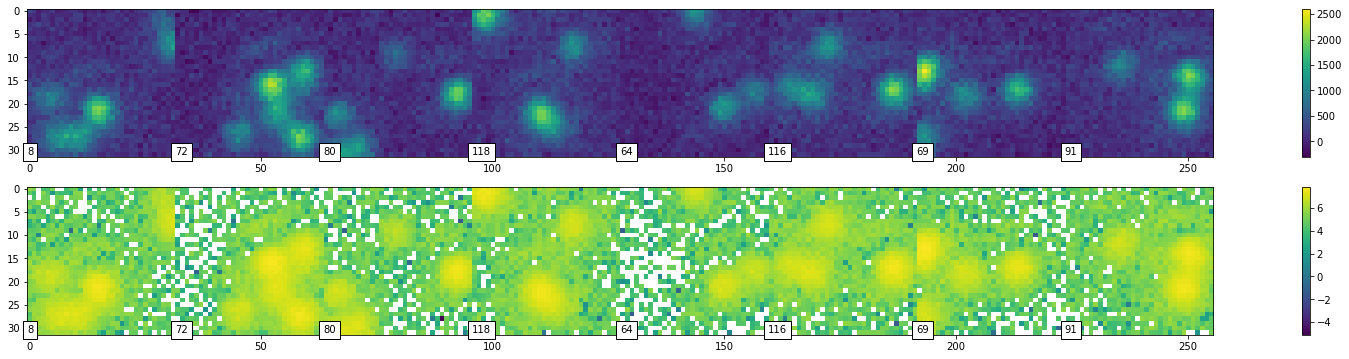

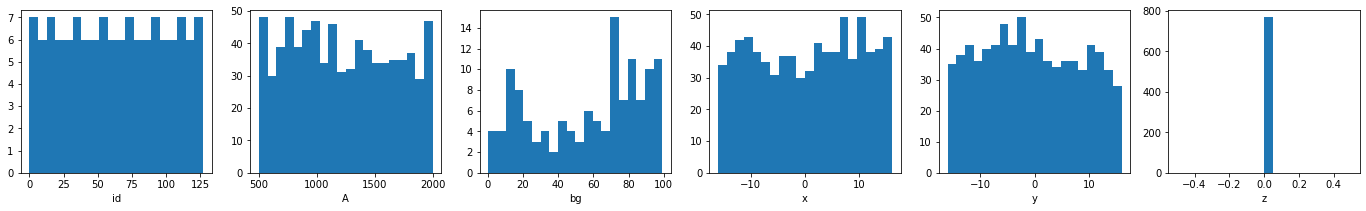

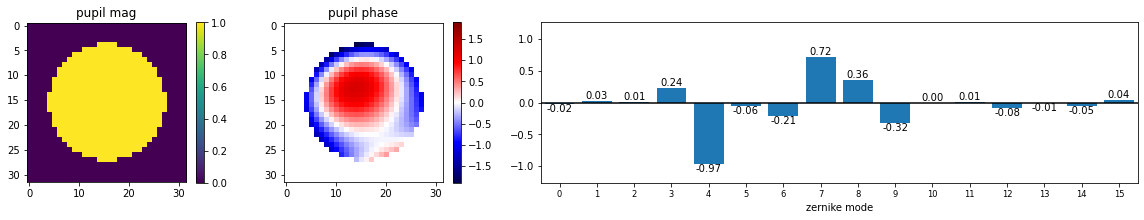

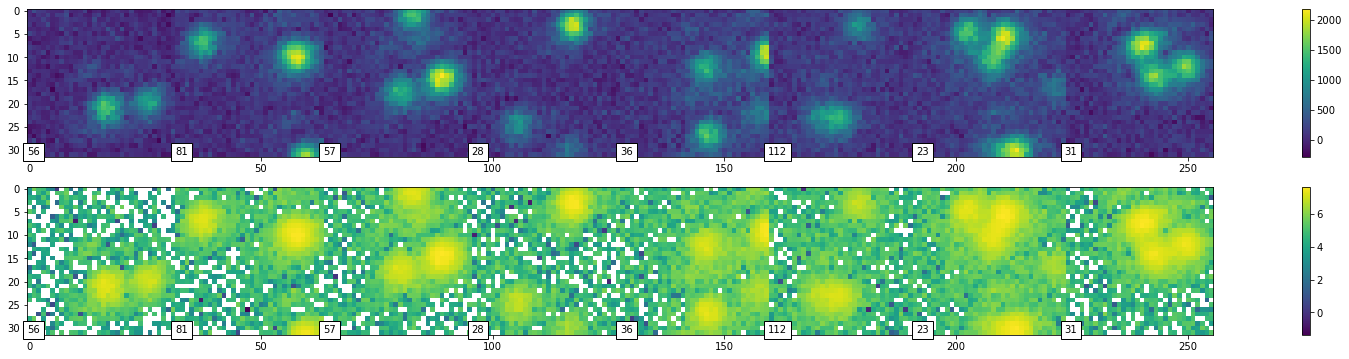

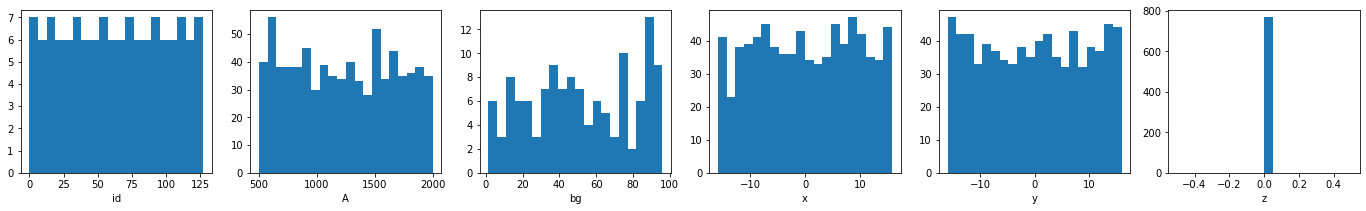

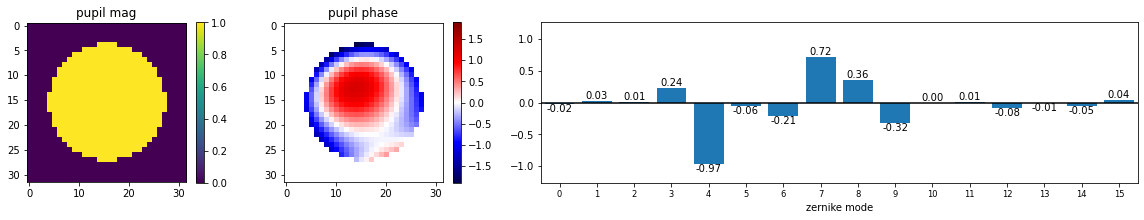

In [2]:
reload(dataset)

settings = {
    'out_size': (32,32),
    'length': (128, 6),
    'dropout_p':0.25,
    'psf_params': {'A': [500, 2000],
                     'bg': [0, 100],
                     'x': [-16, 16],
                     'y': [-16, 16],
                    },
    'psf_zerns': {key: np.random.uniform(-1,1) for key in range(3, 10)},
    'augmentations': {},
    'normalize': False
}

training_data = dataset.FourierOpticsPSFDataset(**settings)
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)


valid_data = dataset.FourierOpticsPSFDataset(**settings)
dataset.inspect_images(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=128, shuffle=True)

C:\Users\kkc29\Anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


CUDA not available. Defaulting to CPU
Device: cpu
Layer (type (var_name))                       Output Shape              Param #
BaseFitModel                                  --                        --
├─UnetEncoderModel (encoder)                  [8, 31, 32, 32]           --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [8, 32, 32, 32]           --
│    │    │    └─Conv2d (0)                   [8, 32, 32, 32]           320
│    │    │    └─ReLU (1)                     [8, 32, 32, 32]           --
│    │    │    └─Conv2d (2)                   [8, 32, 32, 32]           9,248
│    │    │    └─ReLU (3)                     [8, 32, 32, 32]           --
│    │    └─Sequential (pool_layer0)          [8, 32, 16, 16]           --
│    │    │    └─Dropout2d (0)                [8, 32, 32, 32]           --
│    │    │    └─MaxPool2d (1)                [8, 32, 16, 16]           --
│    │    └─Sequential (conv_layer1)     

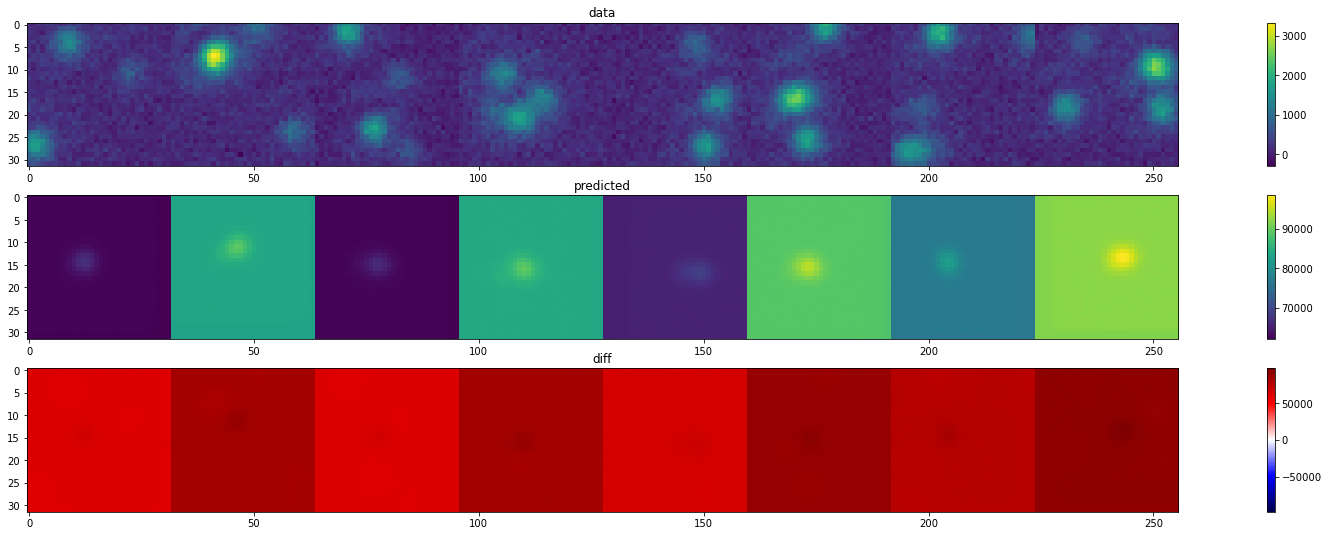

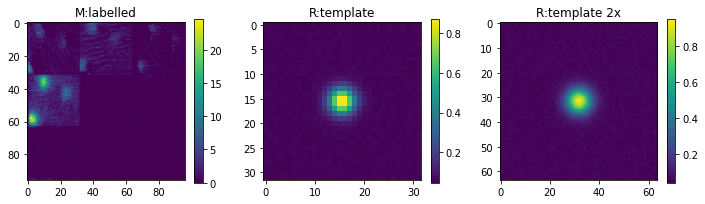

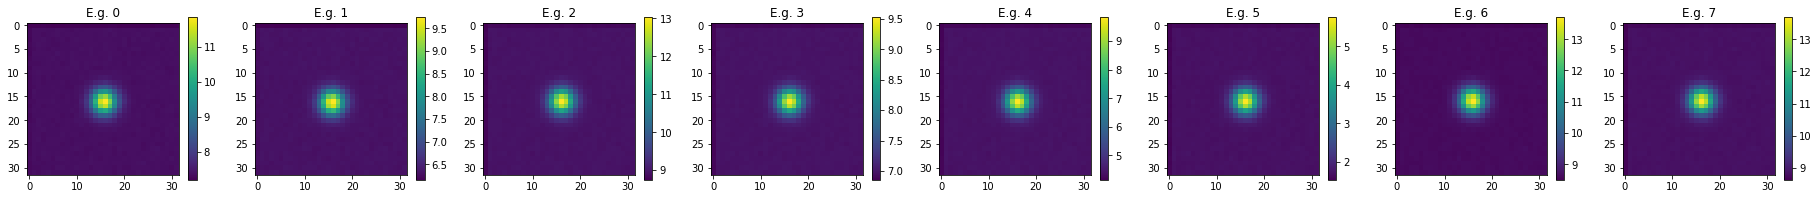

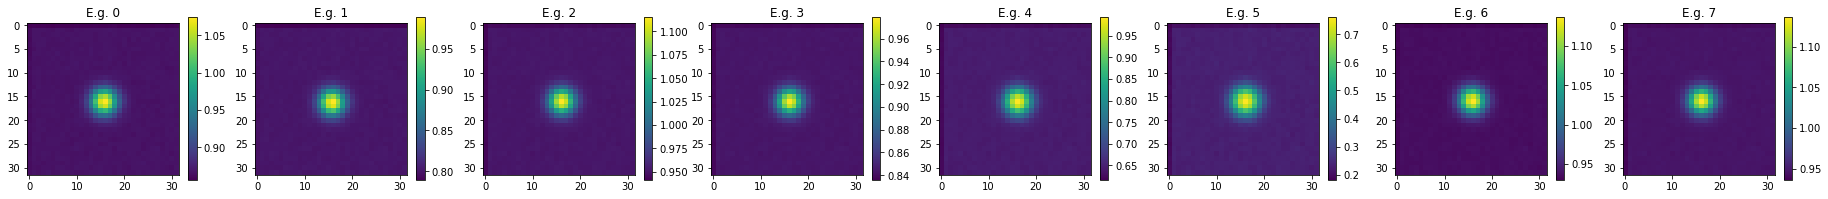

In [3]:
reload(trainer)
reload(model)

params_ref_override = {
            'x': model.FitParameter(nn.Hardtanh(), 0, 20, 0, True),
            'y': model.FitParameter(nn.Hardtanh(), 0, 20, 0, True),
            'A': model.FitParameter(nn.ReLU(), 0., 2000, 1, True),
            'bg': model.FitParameter(nn.Tanh(), 0, 200, 0, False),
}

fitting_model = model.BaseFitModel(renderer_class=model.renderer.Template2DRenderer,
                                   # encoder_class=model.ConvImageEncoderModel,
                                   encoder_class=model.UnetEncoderModel,
                                   # mapper_class=model.mapper.DirectMapperModel,
                                   mapper_class=model.mapper.CentroidMapperModel,
                                   img_size=(32,32),
                                   max_psf_count=10,
                                   fit_params=['x','y','bg','A'],
                                   encoder_params={
                                          # "num_img":len(training_data),
                                          "depth":4,
                                          "first_layer_out_channels":32,
                                          # "skip_channels":16,
                                                     # "init_weights":init_params
                                                     },
                                   # params_ref_override=params_ref_override,
)
                                    # params_ref_no_scale=True)

optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=5e-4)

training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer=optimizer)

# training.train_and_validate(2,)
print(summary(fitting_model, input_size=(8, 1, 32, 32), row_settings=["var_names"], depth=4))
model.check_model(fitting_model, train_dataloader)

In [4]:
print(training.model.mapped_params.keys())

dict_keys(['x', 'y', 'bg', 'A', 'p'])


Saved to : F:\Pytorch\runs\2022-01-05_17-48-15_MW1E008F61_multiemitter_test\model.ptm


  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C:\Users\kkc29\Anaconda3\envs\smlm-dl\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:244.)
  Variable._execution_engine.run_backward(


Saved to : F:\Pytorch\runs\2022-01-05_17-48-15_MW1E008F61_multiemitter_test\checkpoint.ptc
model_state_dict: odict_keys(['mapper.XYS', 'renderer.scale_factor', 'renderer.template.0.parameter', 'encoder.encoders.conv_layer0.0.weight', 'encoder.encoders.conv_layer0.0.bias', 'encoder.encoders.conv_layer0.2.weight', 'encoder.encoders.conv_layer0.2.bias', 'encoder.encoders.conv_layer1.0.weight', 'encoder.encoders.conv_layer1.0.bias', 'encoder.encoders.conv_layer1.2.weight', 'encoder.encoders.conv_layer1.2.bias', 'encoder.encoders.conv_layer2.0.weight', 'encoder.encoders.conv_layer2.0.bias', 'encoder.encoders.conv_layer2.2.weight', 'encoder.encoders.conv_layer2.2.bias', 'encoder.encoders.conv_layer3.0.weight', 'encoder.encoders.conv_layer3.0.bias', 'encoder.encoders.conv_layer3.2.weight', 'encoder.encoders.conv_layer3.2.bias', 'encoder.neck.0.weight', 'encoder.neck.0.bias', 'encoder.neck.2.weight', 'encoder.neck.2.bias', 'encoder.decoders.up_conv_layer0.0.weight', 'encoder.decoders.up_conv_l

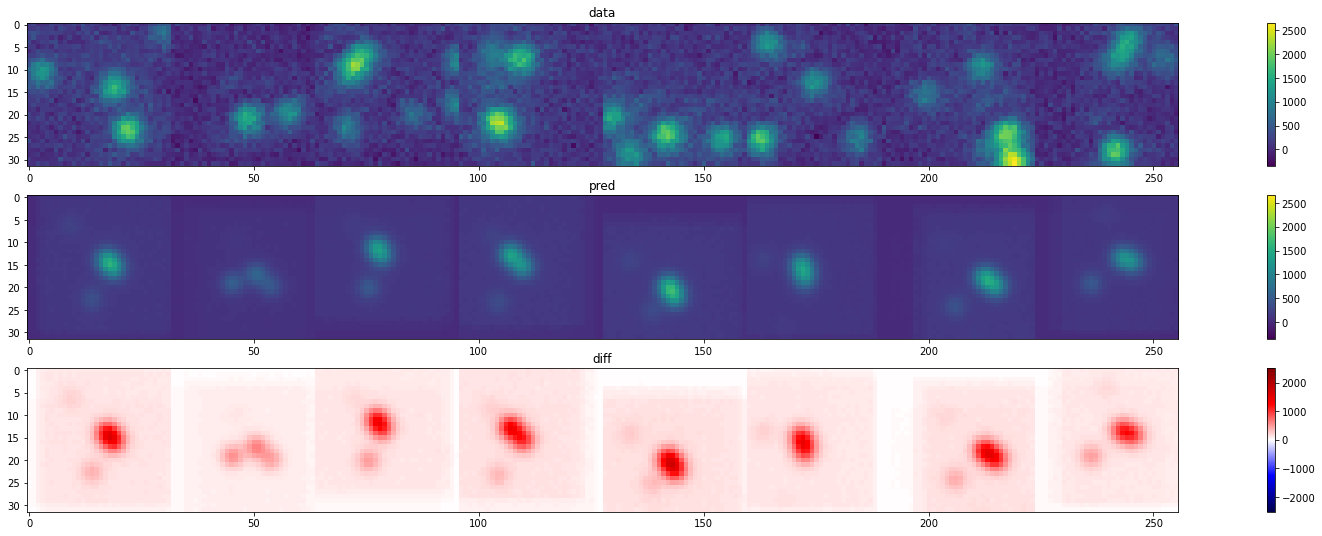

In [5]:
training.train_and_validate(100, training_interval=1, validate_interval=10, label="multiemitter_test", tb_log_limit_images=8)

input shape: (128, 1, 32, 32), output_shape: (128, 1, 32, 32)


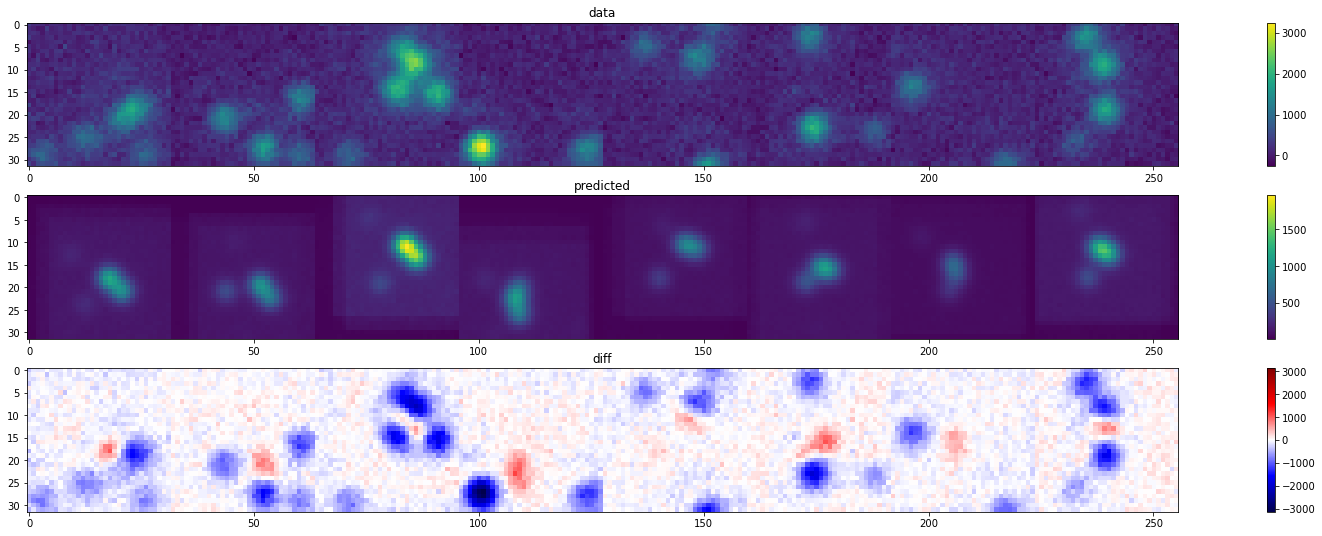

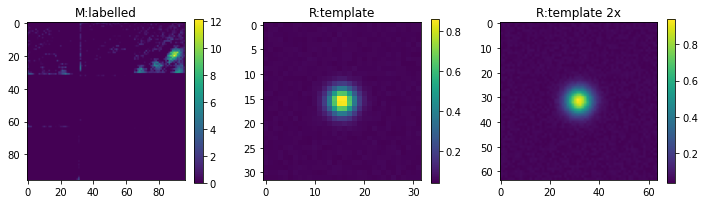

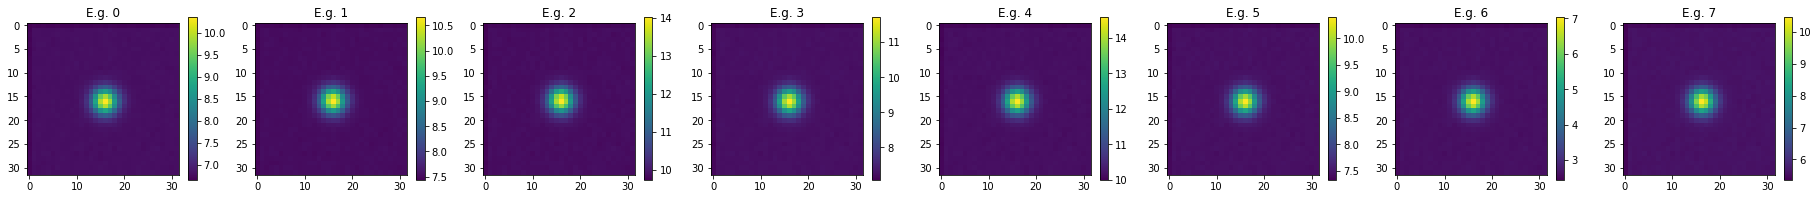

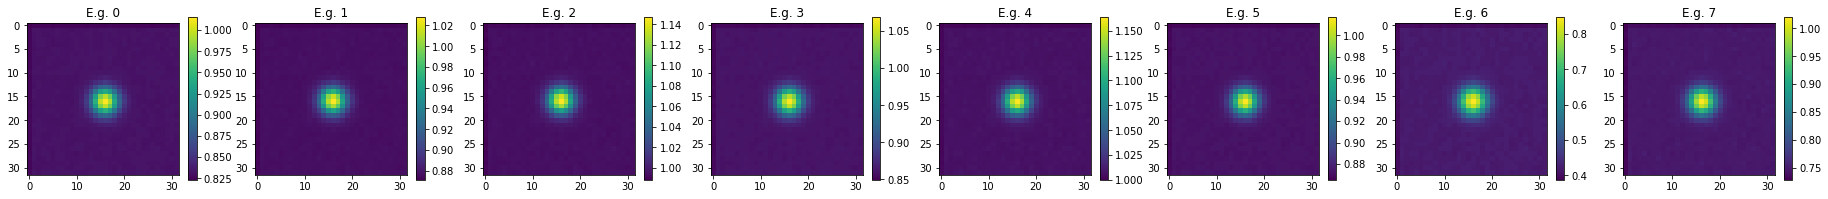

In [6]:
model.check_model(fitting_model, train_dataloader)